In [ ]:
import os
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
from tqdm.auto import tqdm
import pprint


In [2]:
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def IoU(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection area
  # and dividing it by the sum of prediction + ground-truth areas (interesection area)
  IoU = interArea / float(boxAArea + boxBArea - interArea)
  return IoU

# load any word embeddings with format used by Word2Vec, glove, etc.
def load_word_embeddings(file):
  embeddings_dict = {}
  head = True
  with open(file, 'r') as f:
    for line in f:
      if head:
        head = False
        continue
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

In [3]:
def relevance_score(query, image):
  # find spatial score using IoU
  # box coordinates are normalized for 64x64 image
  # TODO: fix box coord bug
  q_box_s, q_box_o = query['data']['s_box'], query['data']['o_box']
  i_box_s, i_box_o = image ['data']['s_box'], image['data']['o_box']
  d = np.sqrt( np.sum( (np.array(q_box_s) - np.array(q_box_o))**2 + (np.array(i_box_s) - np.array(i_box_o))**2 ) )
  s_spatial = math.exp(-d)
  #s_spatial = (IoU(q_box_s, i_box_s) + IoU(q_box_o, i_box_o))/2  + 0.00001
  
  # predicate may have preposition such as "parked on"
  val1 = query['data']['predicate'].split()
  p_q_embed = embeds[val1[0]]
  val2 = image['data']['predicate'].split()
  p_i_embed = embeds[val2[0]]  
  #pred_score = np.dot(p_q_embed, p_i_embed)
    
  # try dot product between concatenated query vector
  q_vec = np.concatenate(( embeds[ query['data']['subject'] ], p_q_embed, embeds[ query['data']['object'] ]), axis=None)/np.sqrt(3)
  i_vec = np.concatenate(( embeds[ image['data']['subject'] ], p_i_embed, embeds[ image['data']['object'] ]), axis=None)/np.sqrt(3)                                                                                                      
  s_semantic = np.dot(q_vec, i_vec) + 0.00001
  
  return s_spatial*s_semantic
  #return (s_spatial+s_semantic)/2

  #alpha = 0.7
  #return alpha*s_spatial + (1-alpha)*s_semantic

In [4]:
def spatial_score(query, image):
  # find spatial score using IoU
  # box coordinates are normalized for 64x64 image
  # TODO: fix box coord bug
  q_box_s, q_box_o = query['data']['s_box'], query['data']['o_box']
  i_box_s, i_box_o = image ['data']['s_box'], image['data']['o_box']
  d = np.sqrt( np.sum( (np.array(q_box_s) - np.array(q_box_o))**2 + (np.array(i_box_s) - np.array(i_box_o))**2 ) )
  s_spatial = math.exp(-d)
  #s_spatial =  (IoU(q_box_s, i_box_s) + IoU(q_box_o, i_box_o))/2 
  return s_spatial

In [5]:
def semantic_score(query, image):
  
  # predicate may have preposition such as "parked on"
  val1 = query['data']['predicate'].split()
  p_q_embed = embeds[val1[0]]
  val2 = image['data']['predicate'].split()
  p_i_embed = embeds[val2[0]]  

  # try dot product between concatenated query vector
  q_vec = np.concatenate(( embeds[ query['data']['subject'] ], p_q_embed, embeds[ query['data']['object'] ]), axis=None)/np.sqrt(3)
  i_vec = np.concatenate(( embeds[ image['data']['subject'] ], p_i_embed, embeds[ image['data']['object'] ]), axis=None)/np.sqrt(3)                                                                                                      
  s_semantic = np.dot(q_vec, i_vec)

  return s_semantic

In [6]:
%%time

# load queries
with open('queries.json') as f:
  queries = json.load(f)

# load images
with open('docs.json') as f:
  images = json.load(f)

CPU times: user 31.5 ms, sys: 3.85 ms, total: 35.3 ms
Wall time: 35.7 ms


In [7]:
%%time
# load word embeddings
embedding_file = "./word_embeddings/numberbatch-en-19.08.txt"
embeds = load_word_embeddings(embedding_file)
print('Done loading word embedding! whee!')

Done loading word embedding! whee!
CPU times: user 27.4 s, sys: 708 ms, total: 28.1 s
Wall time: 28.2 s


In [8]:
%%time

# relevance threshold
relevance_thresh = 0.25
# Q-D matrix of relevances
relevances = np.zeros((len(queries),len(images))) 
all_scores = np.zeros((len(queries),len(images)))
all_labels =  []

# iterate over all queries
print('Processing', len(queries), 'queries')

for n, query in enumerate(tqdm(queries, leave=False)):
  #print('n =', n)
  scores = []
  labels = []
  #print('query:', query['data']['subject'],query['data']['predicate'],query['data']['object'])
  
  # iterate over image db
  for m, image in enumerate(images):
    #print(image)
    # sort by this
    score = relevance_score(query, image)
    #print('image:', image['data']['subject'],image['data']['predicate'],image['data']['object'])
    #print('relevance score = ', score)
    scores.append(score)
    labels.append(image['data']['subject'] + ' ' + image['data']['predicate'] + ' ' + image['data']['object'])
  
  
  # display retrieval
#   scores = np.array(scores)
#   labels = np.array(labels)
#   n_label = len(scores)
#   index = scores.argsort(axis=0)[::-1][:n_label]
#   labels = labels[index]
#   #print('retrieved images:')
#   #print(labels[0:10])
#   # calculate recall (these are "ideal" relevances for this example)
#   relevances[n][np.where(scores[index] > relevance_thresh)] = 1
  all_scores[n] = scores
  all_labels.append(labels)
 

relevances = all_scores > relevance_thresh

Processing 100 queries


CPU times: user 6.32 s, sys: 36.4 ms, total: 6.36 s
Wall time: 6.34 s


In [9]:
sys_scores_sp = np.zeros((len(queries),len(images)))
for n, query in enumerate(tqdm(queries, leave=False)):
  # iterate over image db
  for m, image in enumerate(images):
     sys_scores_sp[n,m] = spatial_score(query, image)

In [10]:
sys_scores_sem = np.zeros((len(queries),len(images)))
for n, query in enumerate(tqdm(queries, leave=False)):
  # iterate over image db
  for m, image in enumerate(images):
     sys_scores_sem[n,m] = semantic_score(query, image)

Text(0.5, 1.05, 'semantic')

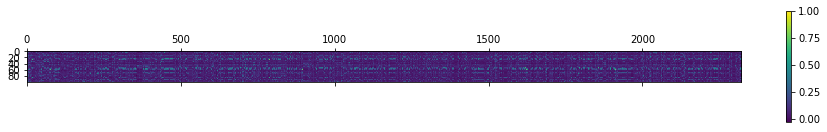

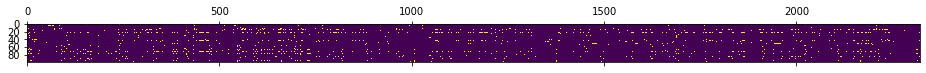

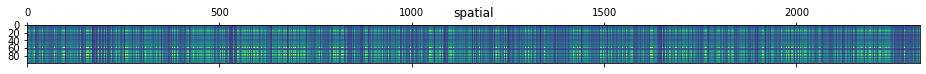

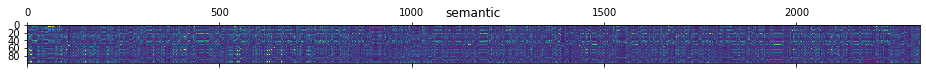

In [11]:
all_scores.shape
plt.matshow(all_scores)
plt.colorbar()
plt.matshow(relevances)
plt.matshow(sys_scores_sp)
plt.title('spatial')
plt.matshow(sys_scores_sem)
plt.title('semantic')


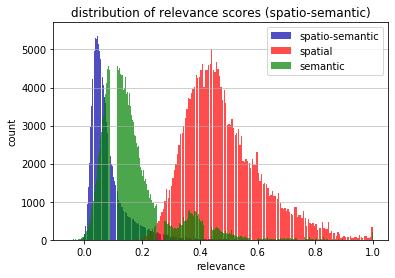

In [12]:

n, bins, patches = plt.hist(x=all_scores.flatten(), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85, label='spatio-semantic')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('relevance')
plt.ylabel('count')
plt.title('distribution of relevance scores (spatio-semantic)')

n, bins, patches = plt.hist(x=sys_scores_sp.flatten(), bins='auto', color='red',
                            alpha=0.7, rwidth=0.85, label='spatial')
n, bins, patches = plt.hist(x=sys_scores_sem.flatten(), bins='auto', color='green',
                            alpha=0.7, rwidth=0.85, label='semantic')
plt.legend()


In [ ]:
# other system
sys_scores = sys_scores_sem
sys_index = np.argsort(sys_scores, axis=1)[:,::-1]
sys_relevances_sort = np.take_along_axis(relevances, sys_index, 1)
sys_recalls = np.cumsum(sys_relevances_sort, 1)/(np.sum(sys_relevances_sort, 1)[:,None] + 1e-12) # [:,None] transposes matrix
sys_mean_recall = np.mean(sys_recalls, axis=0) # column-wise

# ideal: no index needed as we are sorting relevances itself
relevances_sort = np.sort(relevances, axis=1)[:,::-1]
recalls = np.cumsum(relevances_sort, 1)/(np.sum(relevances_sort, 1)[:,None] + 1e-12) # [:,None] transposes matrix
mean_recall = np.mean(recalls, axis=0) # column-wise
plt.matshow(relevances_sort)

# best-case or ideal recall
#pdb.set_trace()
# plot best-case recall
fig = plt.figure()
plt.grid()
plt.xlim(0, len(mean_recall))
plt.xlabel('k')
plt.ylim(0,1.01)
plt.ylabel('Recall at k')
x = np.arange(1,len(mean_recall)+1)
#pdb.set_trace()
plt.plot(x, mean_recall, label="ideal")
plt.plot(x, sys_mean_recall, label="sys")
plt.legend()
plt.show()

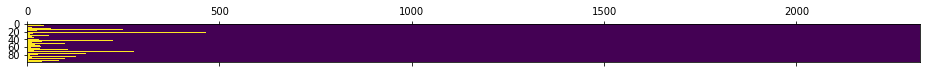

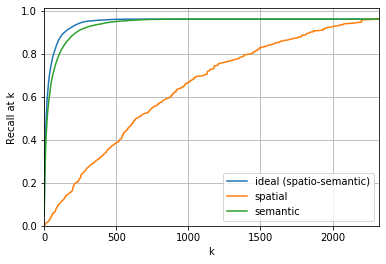

In [13]:
# semantic
sys_scores = sys_scores_sem
sys_index = np.argsort(sys_scores, axis=1)[:,::-1]
sys_relevances_sort = np.take_along_axis(relevances, sys_index, 1)
sys_recalls = np.cumsum(sys_relevances_sort, 1)/(np.sum(sys_relevances_sort, 1)[:,None] + 1e-12) # [:,None] transposes matrix
sys_mean_recall_sem = np.mean(sys_recalls, axis=0) # column-wise

# spatial
sys_scores = sys_scores_sp
sys_index = np.argsort(sys_scores, axis=1)[:,::-1]
sys_relevances_sort = np.take_along_axis(relevances, sys_index, 1)
sys_recalls = np.cumsum(sys_relevances_sort, 1)/(np.sum(sys_relevances_sort, 1)[:,None] + 1e-12) # [:,None] transposes matrix
sys_mean_recall_sp = np.mean(sys_recalls, axis=0) # column-wise

# ideal: no index needed as we are sorting relevances itself
relevances_sort = np.sort(relevances, axis=1)[:,::-1]
recalls = np.cumsum(relevances_sort, 1)/(np.sum(relevances_sort, 1)[:,None] + 1e-12) # [:,None] transposes matrix
mean_recall = np.mean(recalls, axis=0) # column-wise
plt.matshow(relevances_sort)

# best-case or ideal recall
#pdb.set_trace()
# plot best-case recall
fig = plt.figure()
plt.grid()
plt.xlim(0, len(mean_recall))
plt.xlabel('k')
plt.ylim(0,1.01)
plt.ylabel('Recall at k')
x = np.arange(1,len(mean_recall)+1)
#pdb.set_trace()
plt.plot(x, mean_recall, label="ideal (spatio-semantic)")
plt.plot(x, sys_mean_recall_sp, label="spatial")
plt.plot(x, sys_mean_recall_sem, label="semantic")
plt.legend()
plt.show()

In [22]:
# relevances, all_scores, all_labels
sys_scores = sys_scores_sp
sys_index = np.argsort(sys_scores, axis=1)[:,::-1]
sys_scores_sort = np.take_along_axis(sys_scores, sys_index, 1)
#sys_labels_sort = np.take_along_axis(all_labels, sys_index, 1)


sys_labels_sort = []
for n, labels in enumerate(all_labels):
  order = sys_index[n]
  labels = [labels[i] for i in order]
  sys_labels_sort.append(labels)

for n, query in enumerate(queries):  
  # display retrieval
  print('query:', query['data']['subject'],query['data']['predicate'],query['data']['object'])
  print('retrieved images:')
  pprint.pprint(sys_labels_sort[n][0:10])
  breakpoint()
 

query: shelf against wall
retrieved images:
['sign has sign',
 'picture has picture',
 'bed next to bed',
 'bed next to bed',
 'bed next to bed',
 'leaf has leaf',
 'cup inside cup',
 'light over light',
 'bag of bag',
 'building beside building']
> <ipython-input-22-97e8775de29d>(14)<module>()->None
-> for n, query in enumerate(queries):
(Pdb) exit()


BdbQuit: 